### Preparation

In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
# load the data
file_url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
df = pd.read_csv(file_url)

In [3]:
# data preparpation
# select column and lower case their names
relevant_features=['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']
df = df[relevant_features]
df.columns = df.columns.str.replace(' ', '_').str.lower()

# fill missing values with 0
df = df.fillna(0)

# make price binary
df['above_average'] = (df.msrp > df.msrp.mean()).astype(int)
df = df.drop(['msrp'], axis=1)

In [4]:
# shuffle the dataset using seed 42
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

# split the data into train/val/test with 60%/20%/20%
df_full_train, df_test = train_test_split(df_shuffled, test_size=round(len(df)*.2), random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=round(len(df)*.2), random_state=42)

In [5]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['above_average'].values
y_val = df_val['above_average'].values
y_test = df_test['above_average'].values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Question 1

In [7]:
# distinguishing between numerical and categorical variables
cat = ['make', 'model', 'transmission_type', 'vehicle_style']
num = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [8]:
for c in num:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s: %.3f' % (c, auc))

     year: 0.693
engine_hp: 0.918
engine_cylinders: 0.766
highway_mpg: 0.373
 city_mpg: 0.333


### Question 2

In [9]:
# one-hot encode features
def one_hot_encode(train_df, test_df, features):
    train_dict=train_df[features].to_dict(orient='records')
    val_dict=test_df[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
        
    return dv.transform(train_dict), dv.transform(val_dict)

In [10]:
# one-hot encode categorical variables
features = cat+num
X_train, X_val = one_hot_encode(df_train, df_val, features)

In [11]:
# train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
print(f"the model's auc score is: {roc_auc_score(y_val, y_pred):.3f}")

the model's auc score is: 0.983


In [12]:
roc_auc_score(y_val, model.predict(X_val))

0.9235346535184957

### Question 3

In [13]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,642,1741,0,0
10,0.1,639,380,3,1361
20,0.2,626,230,16,1511
30,0.3,604,134,38,1607
40,0.4,589,93,53,1648
50,0.5,570,71,72,1670
60,0.6,532,47,110,1694
70,0.7,492,24,150,1717
80,0.8,428,11,214,1730
90,0.9,335,2,307,1739


In [14]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [16]:
intersection_threshold = np.linspace(0.0,1.0,101)[np.argwhere(np.isclose(df_scores['p'], df_scores['r'], atol=0.01))[0,0]]
print(f"Question 3: Intersection threshold: {intersection_threshold:.2f}")

Question 3: Intersection threshold: 0.50


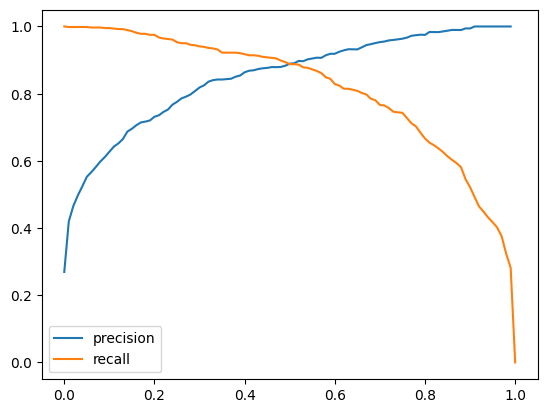

In [17]:
# INSPECTING THE CURVES:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()


### Question 4

In [20]:
df_scores['f1'] = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(df_scores.p, df_scores.r)]

In [21]:
print(f"Question 4: Threshold with maximal F1 score: {df_scores.threshold[df_scores['f1']==max(df_scores['f1'])].values[0]}")

Question 4: Threshold with maximal F1 score: 0.46


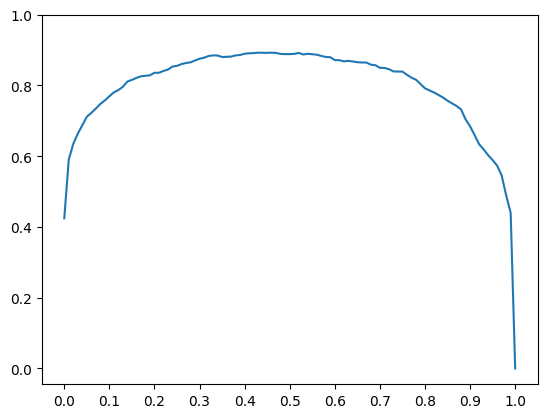

In [22]:
#INSPECTING F1 SCORE:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 6))
plt.show()

### Question 5

In [39]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Iterate over different folds of df_full_train
for train_idx, val_idx in kfold.split(df_full_train):
    # Split the data into train and validation
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.above_average
    y_val = df_val.above_average
    
    del df_train['above_average']
    del df_val['above_average']

    X_train, X_val = one_hot_encode(df_train, df_val, features)

    # train logistic regression model
    # Train the model on train with these parameters: 
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)

    # Use AUC to evaluate the model on validation
    scores.append(roc_auc_score(y_val, y_pred))
    
# How large is standard devidation of the scores across different folds?
print('%.3f' % (np.std(scores)))

0.009


### Question 6

In [63]:
scores = []

# Iterate over the following C values: [0.01, 0.1, 0.5, 10]
for C in [0.01, 0.1, 0.5, 10]:
    auc_scores = []

    # Initialize KFold with the same parameters as previously
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Iterate over different folds of df_full_train
    for train_idx, val_idx in kfold.split(df_full_train):
        # Split the data into train and validation
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        del df_train['above_average']
        del df_val['above_average']

        X_train, X_val = one_hot_encode(df_train, df_val, features)

        # train logistic regression model
        # Use these parametes for the model: 
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
    
        # Use AUC to evaluate the model on validation
        auc_scores.append(roc_auc_score(y_val, y_pred))
    
    #Compute the mean score as well as the std    
    scores.append((C, np.round(np.mean(auc_scores), 3), np.round(np.std(auc_scores), 3)))
    
df_c_scores = pd.DataFrame(scores, columns=['C', 'mean', 'std'])

In [64]:
df_c_scores[df_c_scores['mean']==max(df_c_scores['mean'])]['C']

3    10.0
Name: C, dtype: float64